# Ambulance

## Aims:

Compares people who arrived by ambulance to those who did not. This includes visualisations that look at the relationships over time, since the proportion arriving by ambulance has changed so much over time.

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(
    paths.data_path, paths.admission_only_filename))

## Reformat data

Drop the few patients who are missing data on whether they arrived by ambulance.

In [4]:
data_full = data_full[data_full['arrive_by_ambulance'].notna()]

Create columns with month and year, or quarter and year.

In [5]:
# Create datetime with month and year
data_full['month_year_dt'] = pd.to_datetime(
    data_full['year'].astype(str) + '-' +
    data_full['month'].astype(str), format='%Y-%m')

# Convert to period of m (month and year)
data_full['month_year'] = data_full['month_year_dt'].dt.to_period('m')

# Convert to period of q (quarter and year)
data_full['quarter_year'] = data_full['month_year_dt'].dt.to_period('q')

Add stroke severity groups

In [6]:
conditions = [(data_full['stroke_severity'] == 0),
              (data_full['stroke_severity'].isin(np.arange(1, 5))),
              (data_full['stroke_severity'].isin(np.arange(5, 16))),
              (data_full['stroke_severity'].isin(np.arange(16, 21))),
              (data_full['stroke_severity'].isin(np.arange(21, 43)))]
nihss_choices = ['A: 0', 'B: 1-4', 'C: 5-15', 'D: 16-20', 'E: 21-42']
data_full['stroke_severity_groups'] = np.select(conditions, nihss_choices)

Add column where ambulance arrival is yes/no rather than 1/0.

In [7]:
data_full['arrive_by_ambulance_lab'] = (
    data_full['arrive_by_ambulance'].map({0: 'No', 1: 'Yes'}))

Creating dataframe with just patients who arrived within 4 hours of known onset

In [8]:
data_4h = data_full[(data_full['onset_known'] == 1) &
                    (data_full['onset_to_arrival_time'] <= 4*60)]

## Functions

In [9]:
def proportion_arrivals(group, xlab, ax,
                        type='line', dataset=data_full, title=None):
    '''
    Plot the proportion of patients arriving by ambulance in
    the specified groups of patients
    group: string, with categories to find proportions in
    xlab: string, x axis label
    ax: axis object to plot on
    type: type of graph, 'line' or 'bar'
    dataset: dataframe to use, default is data_full
    '''
    # Find proportions
    df = dataset.groupby(group)['arrive_by_ambulance'].mean()

    if type == 'line':
        # Create line plot
        df.plot(kind='line', marker='o', markersize=2, ax=ax)
        # Set title
        ax.set_title('Proportion of patients arriving by ambulance\n' +
                     'for each ' + xlab.lower(), fontsize=10)
    elif type == 'bar':
        # Create bar plot
        df.plot(kind='bar', ax=ax)
        # Set title
        ax.set_title(title, fontsize=10)

    # Set x and y label
    ax.set_xlabel(xlab)
    ax.set_ylabel('Proportion of patients\narriving by ambulance')

In [10]:
def proportions_by_arrival(col, xlab, ax, type, bin_pos=0,
                           alt_m='No', alt_title='No',
                           alt_bins='No', alt_bins_array=[0, 1, 2],
                           dataset=data_full, width=1):
    '''
    Plots the proportions of patients in the specified columns categories,
    from a dataset split into whether arrived by ambulance or not. Creates
    overlaid histograms or bar charts with a mean line for each.
    col: string, groups of interest
    xlab: string, label for x axis (also used for title)
    ax: axis object to plot on
    type: type of graph, enter 'hist' or 'bar'
    bin_pos: number, optional, to modify bin positioning
    alt_m: string, optional, if alternative column for mean calculation
    (if providing different columns due to pre-processing/bin locations)
    alt_bins: whether providing alternative bin method
    alt_bins_array: optional arrival to provide when alt_bins == 'Yes'
    alt_title: string, optional, can provide an alternative title
    dataset: dataframe to use, default is data_full
    '''
    # Seperate ambulance and non-ambulance
    amb = dataset['arrive_by_ambulance'] == 1
    amb_df = dataset.loc[amb, col]
    non_df = dataset.loc[~amb, col]

    # Define bins - default is one bin per unique value - or alt_bins provided
    if alt_bins == 'No':
        unique = len(dataset[col].unique())
        bins = np.sort(dataset[col].unique())
        bins = np.append(bins, bins.max() + bins[1] - bins[0])
    elif alt_bins == 'Yes':
        bins = alt_bins_array

    if type == 'hist':
        # Plot overlaid histograms
        ax.hist(non_df, bins, weights=np.ones(len(non_df))/len(non_df),
                alpha=0.5, label='No', rwidth=width)
        ax.hist(amb_df, bins, weights=np.ones(len(amb_df))/len(amb_df),
                alpha=0.5, label='Yes', rwidth=width)

        # Add mean lines
        if alt_m == 'No':
            amb_m = amb_df.mean()
            non_m = non_df.mean()
        else:
            amb_m = dataset.loc[amb, alt_m].mean()
            non_m = dataset.loc[~amb, alt_m].mean()
        ax.axvline(non_m, color='C0', linestyle='dashed', alpha=0.65)
        ax.axvline(amb_m, color='orange', linestyle='dashed', alpha=0.65)
        # Ending for title mentioning mean line
        title_end = '\n(with line for mean ' + xlab.lower() + ')'

    elif type == 'bar':
        # Group by ambulance and find proportions in each category of column
        toplot = (dataset
                  .groupby('arrive_by_ambulance_lab')[col]
                  .value_counts(normalize=True)
                  .unstack(level=1))
        # Plot grouped bar charts
        toplot.T.plot(kind='bar', ax=ax)
        # No ending for title
        title_end = ''

    # Add legend, labels and titles
    order = [1, 0]
    ax.legend(title='Ambulance', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(xlab)
    ax.set_ylabel('Proportion (grouped by ambulance v.s. not)')
    ax.set_title('Proportion of patients of each ' + xlab.lower() + '\n' +
                 'when grouped by whether they arrived by ambulance' +
                 title_end, fontsize=10)

    if alt_title != 'No':
        ax.set_title(alt_title, fontsize=10)

In [11]:
def mean_over_time(col, xlab, ax, dataset=data_full, alt_title='No'):
    '''
    Plot the mean of the column over time, when data is grouped
    by whether arrived by ambulance
    col: string, column of interest
    xlab: string, x axis label
    ax: axis object to plot on
    dataset: dataframe to use, default is data_full
    alt_title: string, optional, can provide an alternative title
    '''
    # Seperate by whether arrived by ambulance
    amb = dataset['arrive_by_ambulance'] == 1
    amb_df = dataset.loc[amb]
    non_df = dataset.loc[~amb]

    # Find mean of col in each month for ambulance v.s. non-ambulance patients
    non_plt = non_df.groupby('quarter_year')[col].mean()
    amb_plt = amb_df.groupby('quarter_year')[col].mean()

    non_plt.plot(kind='line', ax=ax, marker='o', markersize=2, label='No')
    amb_plt.plot(kind='line', ax=ax, marker='o', markersize=2, label='Yes')

    plt.ylabel('Mean ' + xlab)
    plt.title('Mean ' + xlab + ' over time by ambulance arrival', fontsize=10)
    plt.legend(title='Ambulance')

    if alt_title != 'No':
        plt.title(alt_title, fontsize=10)

In [12]:
def plot_by_severity(col, lab, dataset):
    '''
    Plots mean of column by ambulance arrival and strong severity
    col: string, column of interest
    lab: string, label for use in axis and title
    dataset: dataframe to use (e.g. data_full, onset_data)
    '''
    # Mean arrival to scan time by stroke severity (groups)
    # and whether arrived by ambulance
    df = (dataset
          .groupby(['arrive_by_ambulance_lab',
                    'stroke_severity_groups'])[col]
          .mean()
          .reset_index(name='mean'))

    # Initialise figure
    fig, ax = plt.subplots(figsize=(5, 4))

    # Group dataframe by ambulance arrival
    grouped = df.groupby('arrive_by_ambulance_lab')

    # Plot lines
    grouped.plot(x='stroke_severity_groups', y='mean', ax=ax,
                 marker='o', markersize=3)

    # Correct legend
    ax.legend(labels=grouped.groups.keys(), title='Ambulance')

    # Add axis labels and show plot
    ax.set_ylabel('Mean ' + lab.lower())
    ax.set_xlabel('Stroke severity group')
    ax.set_title('Mean ' + lab.lower() + ' by stroke severity\n' +
                 'and whether arrived by ambulance', fontsize=10)
    plt.show()

## Frequency of ambulance arrivals

Observations:
* Overall **79% patients arrived by ambulance**.
* **Proportion of arrivals by ambulance is decreasing** - it was decreasing from 2016 to 2020, then increased with the first COVID-19 lockdown, and decreased over 2021 (duplicates analysis from comparison over time notebook).

,index,n,percent
0,1.0,283190,78.910484
1,0.0,75685,21.089516


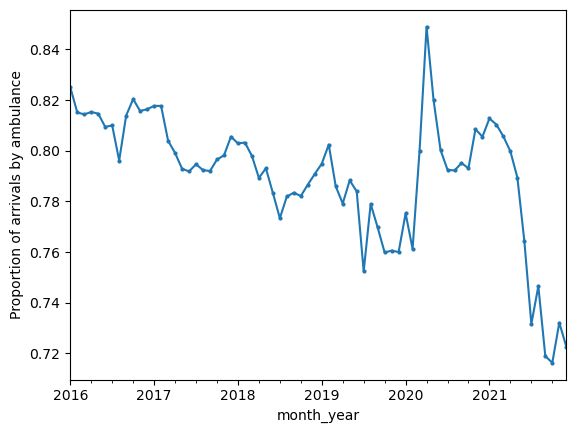

In [13]:
# Find overall frequency
freq = data_full['arrive_by_ambulance'].value_counts().reset_index(name='n')
freq['percent'] = freq['n']/freq['n'].sum()*100
display(freq)

# Plot frequency over time (grouped by month)
df = data_full.groupby('month_year')['arrive_by_ambulance'].mean()
df.plot(kind='line', marker='o', markersize=2)
plt.ylabel('Proportion of arrivals by ambulance')
plt.show()

## Characteristics of patients who arrive by ambulance v.s. not

All variables are included in the summary table, and then some are explored in more detail in visualisations (not all due to time to produce figures)

### Summary table

Observations that patients who arrive by ambulance (compared to those who did not), are on average:
* Higher age
* Lower proportion male
* Lower proportion infarction
* Shorter onset to arrival time
* Greater proportion onset known (and precise onest known)
* Similar proportion onset during sleep
* Shorter arrival to scan time, scan to thrombolysis time, or arrival to thrombectomy time
* Higher proportion thrombolysed or receive thrombectomy
* Higher proportion with comorbidities (except diabetes)
* Higher proportion on anticoagulants
* Higher prior disability
* More severe stroke (and so higher proportion meeting each NIHSS criteria)
* Lower proportion with complete NIHSS
* More deaths
* Higher disability at discharge and six months
* Higher proportion who did not receive thrombolysis for reasons of: haemorrhagic, comorbidity, medication, refusal, age, improving, other medical
* Lower proportion have reason of: lower time window, too mild/severe, time unknown wake up (and therefore, these reasons are higher in patients who did not arrive by ambulance)

In [14]:
# Drop columns that are not appropriate to compare
# (removed "thrombolysis no" due to low numbers)
drop = ['id', 'month', 'year', 'call_to_ambulance_arrival_time',
        'ambulance_on_scene_time', 'ambulance_travel_to_hospital_time',
        'ambulance_wait_time_at_hospital', 'arrival_time_3_hour_period',
        'thrombolysis_no_not_available', 'thrombolysis_no_out_of_hours',
        'thrombolysis_no_scan_not_quick_enough', 'thrombolysis_no_no_reason']

# Groupby ambulance arrival and find mean and median of all other columns
mean = (data_full
        .drop(drop, axis=1)
        .groupby('arrive_by_ambulance')
        .mean(numeric_only=True)
        .T)
median = (data_full
          .drop(drop, axis=1)
          .groupby('arrive_by_ambulance')
          .median(numeric_only=True)
          .T)
pd.concat({'mean': mean, 'median': median}, axis=1)

mean              median  \
arrive_by_ambulance                               0.0          1.0    0.0   
age                                         69.241428    75.572284   72.5   
male                                         0.584290     0.514658    1.0   
infarction                                   0.917183     0.867354    1.0   
onset_to_arrival_time                     2449.159008  1514.614941  577.0   
onset_known                                  0.538284     0.705371    1.0   
precise_onset_known                          0.241356     0.361418    0.0   
onset_during_sleep                           0.131691     0.137155    0.0   
arrival_to_scan_time                       246.715452   181.807730  103.0   
thrombolysis                                 0.041025     0.134306    0.0   
scan_to_thrombolysis_time                   41.290821    36.845954   34.0   
thrombectomy                                 0.003118     0.014446    0.0   
arrival_to_thrombectomy_time               231.250000   219.646786  174.5   
congestive_heart_failure                     0.031658     0.053921    0.0   
hypertension                                 0.518319     0.548949    1.0   
atrial_fibrillation                          0.110709     0.201165    0.0   
diabetes                                     0.216027     0.213648    0.0   
prior_stroke_tia                             0.202788     0.267467    0.0   
afib_antiplatelet                            0.015353     0.031145    0.0   
afib_anticoagulant                           0.118995     0.187691    0.0   
afib_vit_k_anticoagulant                     0.018762     0.027197    0.0   
afib_doac_anticoagulant                      0.050023     0.076472    0.0   
afib_heparin_anticoagulant                   0.000687     0.001042    0.0   
new_afib_diagnosis                           0.039871     0.074278    0.0   
prior_disability                             0.567986     1.157152    0.0   
stroke_severity                              3.221405     8.087242    2.0   
nihss_complete                               0.960111     0.939486    1.0   
nihss_arrival_loc                            0.046905     0.267019    0.0   
nihss_arrival_loc_questions                  0.196259     0.626388    0.0   
nihss_arrival_loc_commands                   0.079112     0.346676    0.0   
nihss_arrival_best_gaze                      0.077835     0.292255    0.0   
nihss_arrival_visual                         0.289780     0.441909    0.0   
nihss_arrival_facial_palsy                   0.353690     0.748477    0.0   
nihss_arrival_motor_arm_left                 0.297386     0.773739    0.0   
nihss_arrival_motor_arm_right                0.257380     0.732572    0.0   
nihss_arrival_motor_leg_left                 0.270348     0.799642    0.0   
nihss_arrival_motor_leg_right                0.239512     0.766623    0.0   
nihss_arrival_limb_ataxia                    0.264772     0.279972    0.0   
nihss_arrival_sensory                        0.254554     0.457295    0.0   
nihss_arrival_best_language                  0.270301     0.740287    0.0   
nihss_arrival_dysarthria                     0.305170     0.671046    0.0   
nihss_arrival_extinction_inattention         0.118309     0.407500    0.0   
death                                        0.031725     0.167471    0.0   
discharge_disability                         1.649823     2.917954    1.0   
disability_6_month                           1.572932     2.374898    1.0   
thrombolysis_no_but_haemorrhagic             0.085644     0.135693    0.0   
thrombolysis_no_but_time_window              0.498078     0.269543    0.0   
thrombolysis_no_but_comorbidity              0.013067     0.039945    0.0   
thrombolysis_no_but_medication               0.022144     0.045701    0.0   
thrombolysis_no_but_refusal                  0.001189     0.002994    0.0   
thrombolysis_no_but_age                      0.002167     0.006497    0.0   
thrombolysis_no_but_improving                

### Stroke severity

Observations:
* At greater stroke severities, a higher proportion of patients arrive by ambulance.
* From apx. NIHSS 0 to 10 the proportion increases before plateuing around NIHSS 10-15, where the proportion is roughly 95%+.
* Relatedly, patients arriving by ambulance typically had more severe strokes.
* Mean stroke severity over time has some seasonal variation, with slight trends observable (but often within range of normal variation) - e.g. lower mean stroke severity of ambulance arrivals in mid-2020 to 21, but not in non-ambulance-arrivals

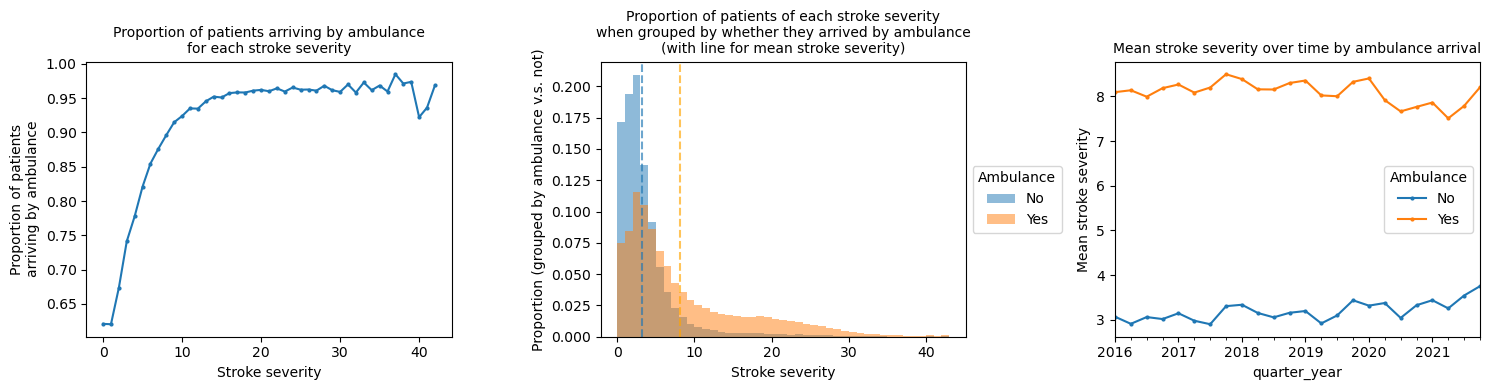

In [15]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('stroke_severity', 'Stroke severity', ax=ax[0])
proportions_by_arrival('stroke_severity', 'Stroke severity',
                       ax=ax[1], type='hist')
mean_over_time('stroke_severity', 'stroke severity', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Age

Observations:
* In higher age groups, a greater proportion of patients arriving by ambulance
* Relatedly, the average age of patients arriving by ambulance was older.
* Mean age over time is very variable.

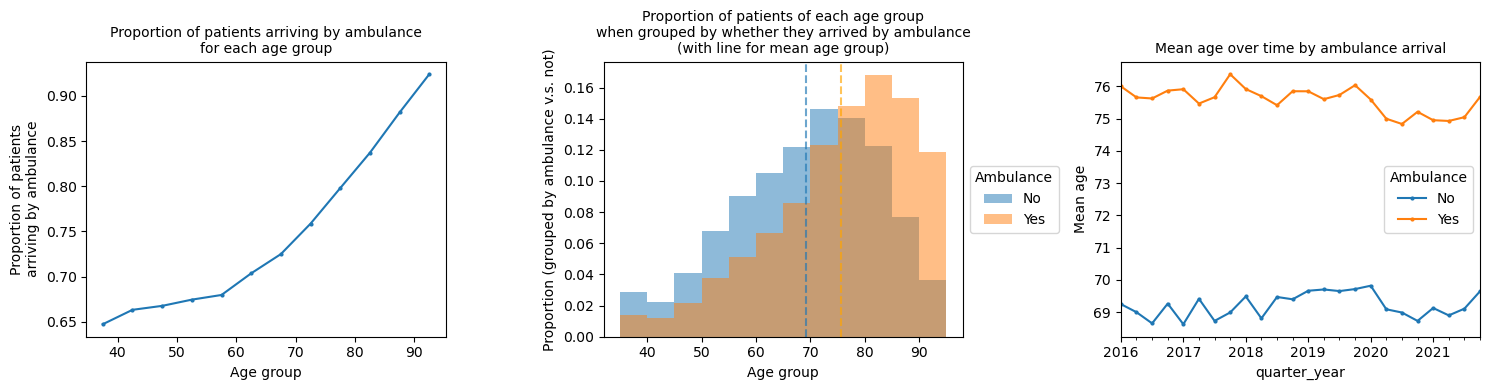

In [16]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create column where age is the base of the category
data_full['age_base'] = data_full['age'] - 2.5

# Create plots
proportion_arrivals('age', 'Age group', ax=ax[0])
proportions_by_arrival('age_base', 'Age group',
                       ax=ax[1], type='hist', alt_m='age')
mean_over_time('age', 'age', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Discharge disability

Observations:
* Proportion arriving by ambulance increases with discharge disability
* Relatedly, average discharge disability of patients who arrived by ambulance is higher
* Mean discharge disability of patients arriving by ambulance has seasonal variation but no clear overall trend - whilst the mean of patients who do not arrive by ambulance appears to be gradually increasing over time

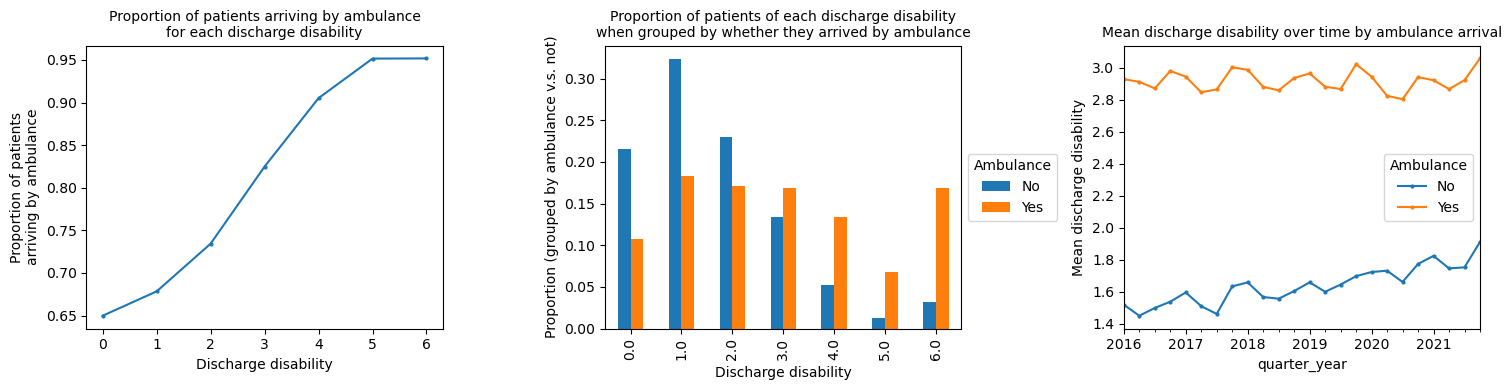

In [17]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('discharge_disability',
                    'Discharge disability', ax=ax[0])
proportions_by_arrival('discharge_disability', 'Discharge disability',
                       ax=ax[1], type='bar')
mean_over_time('discharge_disability', 'discharge disability', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Prior disability

Observations:
* Proportion arriving by ambulance increases with prior disability
* Relatedly, a greater proportion of patients at higher stroke severities arrive by ambulance, and vice versa
* Over time, the mean prior disability appears to increase for non-ambulance arrivals, and likewise for ambulance arrivals but with a dip in 2020.

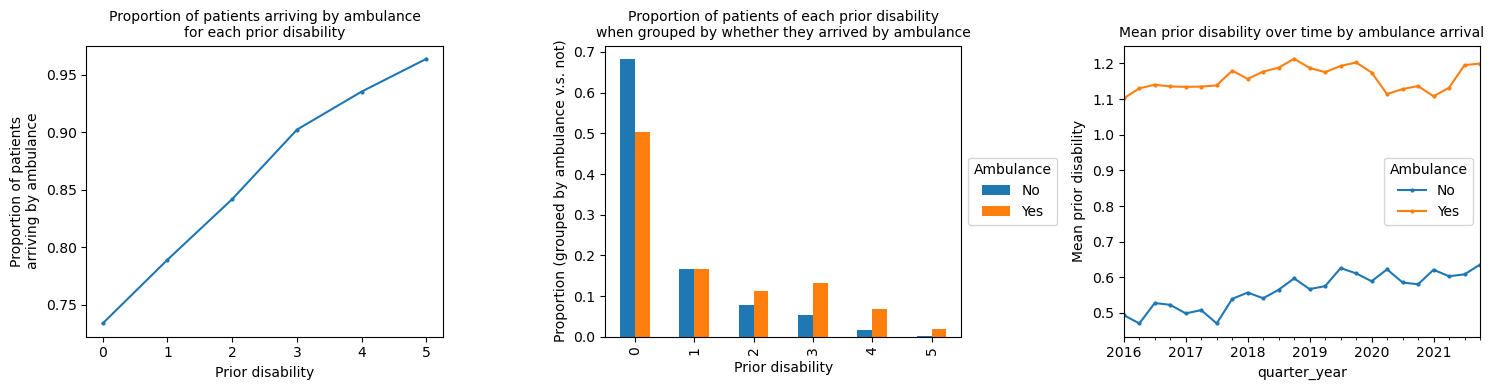

In [18]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('prior_disability', 'Prior disability', ax=ax[0])
proportions_by_arrival('prior_disability', 'Prior disability',
                       ax=ax[1], type='bar')
mean_over_time('prior_disability', 'prior disability', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Disability at 6 months

Observations:
* The proportion of patients who arrived by ambulance is greater for patients with a higher disability at 6 months (though proportion for mRS 5 is lower than mRS 6)
* Relatedly, there were a greater proportion of patients of lower disabilities at 6 months in those who did not arrive by ambulance. Likewise, for example, a higher proportion of patients who arrived by ambulance had mRS 6 at 6 months, than non-ambulance-arrivals
* Mean disability at 6 months is quite variable, but appears to be increasing for non-ambulance arrivals

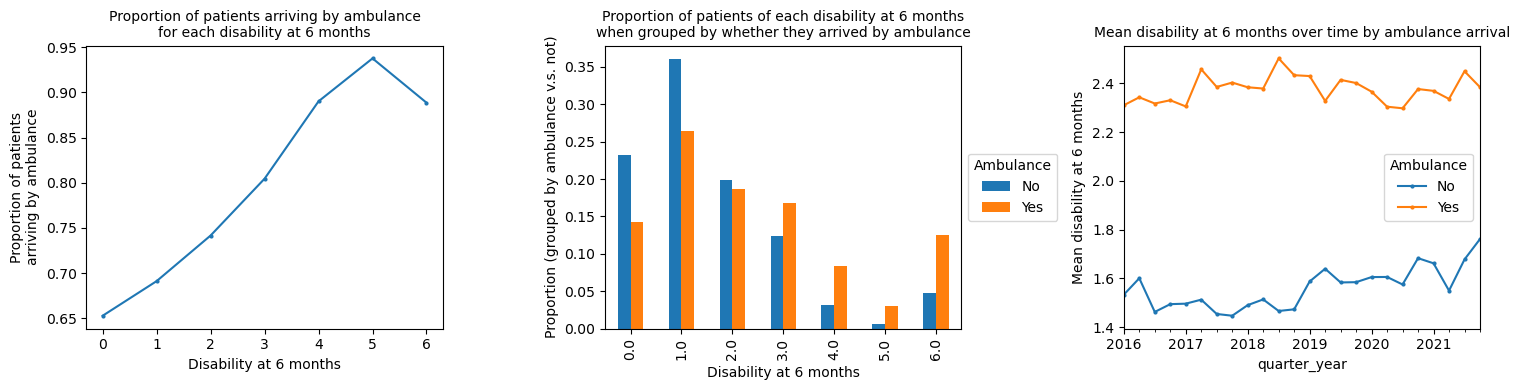

In [19]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
proportion_arrivals('disability_6_month', 'Disability at 6 months', ax=ax[0])
proportions_by_arrival('disability_6_month', 'Disability at 6 months',
                       ax=ax[1], type='bar')
mean_over_time('disability_6_month', 'disability at 6 months', ax=ax[2])

# Show plots
plt.tight_layout()
plt.show()

### Thrombolysis

Observations:
* Greater proportion of thrombolysed patients arrive by ambulance
* Relatedly, greater proportion of patients who arrived by ambulance are thrombolysed
* The proportion of ambulance arrivals thrombolysed since early 2020 appears to have decreased, whilst the proportion of non-ambulance arrivals thrombolysed appears to have increased... although you see this less when looking at proportion thrombolysed who those with known onset who arrived within four hours

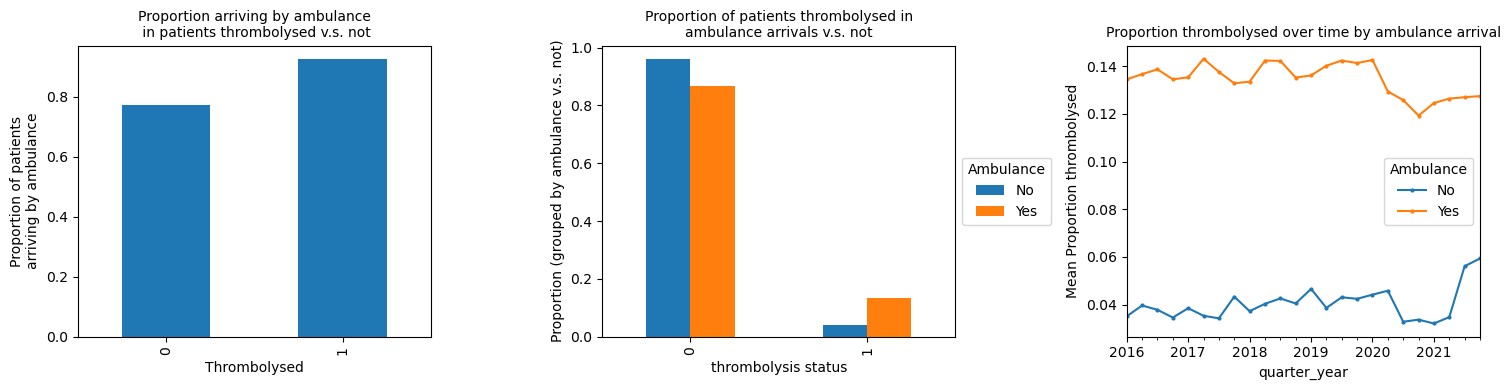

In [20]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
title = 'Proportion arriving by ambulance\n in patients thrombolysed v.s. not'
proportion_arrivals('thrombolysis', 'Thrombolysed',
                    ax=ax[0], type='bar', title=title)

title = 'Proportion of patients thrombolysed in\nambulance arrivals v.s. not'
proportions_by_arrival('thrombolysis', 'thrombolysis status',
                       ax=ax[1], type='bar', alt_title=title)

title = 'Proportion thrombolysed over time by ambulance arrival'
mean_over_time('thrombolysis', 'Proportion thrombolysed',
               ax=ax[2], alt_title=title)

# Show plots
plt.tight_layout()
plt.show()

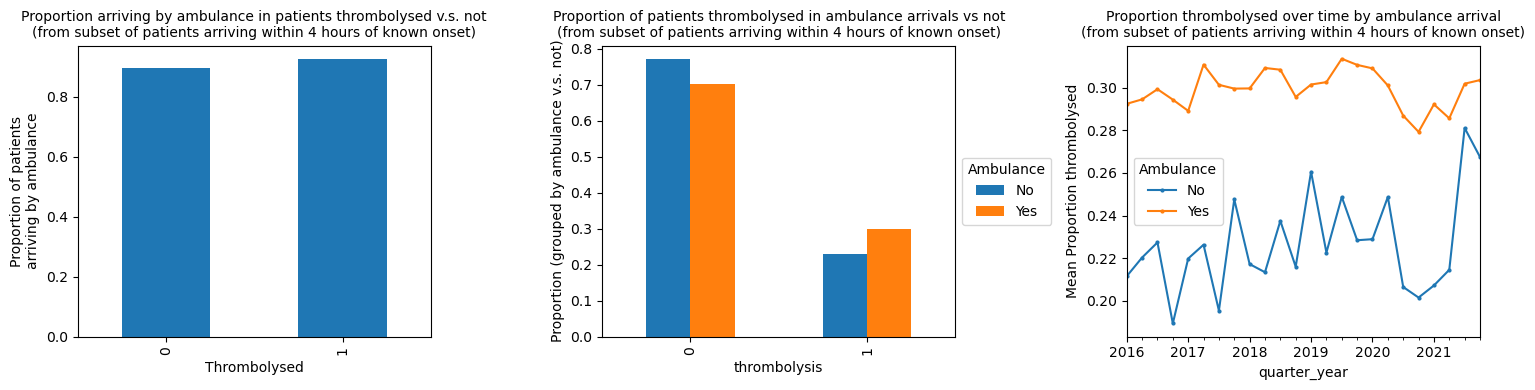

In [21]:
# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Create plots
title = ('Proportion arriving by ambulance in ' +
         'patients thrombolysed v.s. not\n' +
         '(from subset of patients arriving within 4 hours of known onset)')
proportion_arrivals('thrombolysis', 'Thrombolysed',
                    ax=ax[0], type='bar', dataset=data_4h, title=title)

title = ('Proportion of patients thrombolysed in ambulance arrivals vs not\n' +
         '(from subset of patients arriving within 4 hours of known onset)')
proportions_by_arrival('thrombolysis', 'thrombolysis',
                       ax=ax[1], type='bar', dataset=data_4h, alt_title=title)

title = ('Proportion thrombolysed over time by ambulance arrival\n' +
         '(from subset of patients arriving within 4 hours of known onset)')
mean_over_time('thrombolysis', 'Proportion thrombolysed',
               ax=ax[2], dataset=data_4h, alt_title=title)

# Show plots
plt.tight_layout()
plt.show()

### Onset to arrival time

Note: Analysis excludes onset to arrival times over 24 hours due to focus on emergency pathway and exclusion of anomalous times when using means.

Observations:
* A higher proportion of patients with shorter onset to arrival times, arrived by ambulance
* Relatedly, a greater proportion of patients who arrived by ambulance had shorter onset to arrival times
* Over the years, the mean onset to arrival time of ambulance arrivals has increased, whilst the arrival times of non-ambulance-users are more variable, with a drop in times in the second half of 2021.

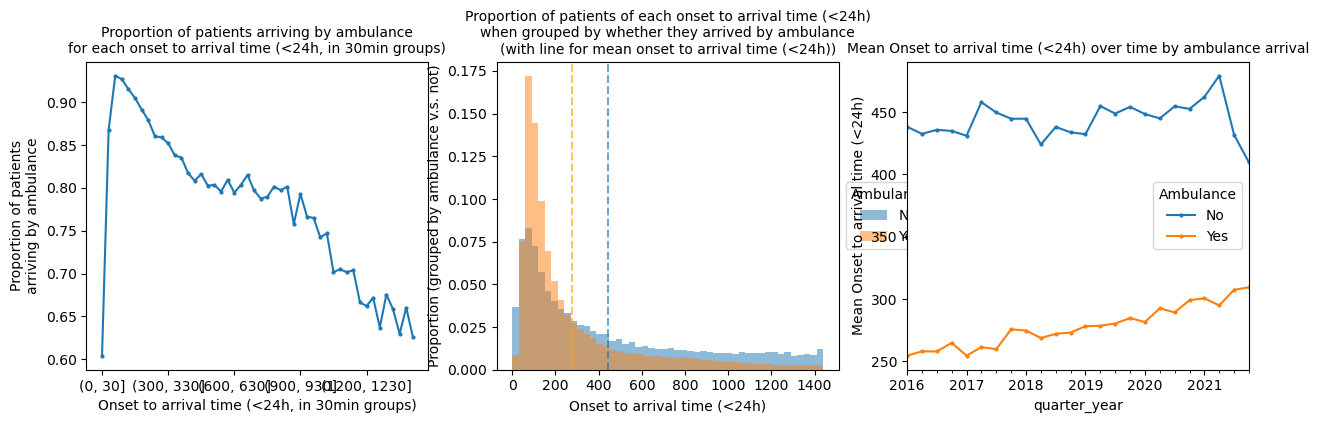

In [22]:
max = 24*60

# Convert continuous times into categories (every 30 minutes)
bins = np.arange(0, max+30, 30)
data_full['onset_arrival_cat'] = pd.cut(
    data_full['onset_to_arrival_time'], bins=bins)

# Drop times over 24 hours
onset_data = data_full[data_full['onset_to_arrival_time'] <= max]

# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Proportion arriving by ambulance in each time bucket
proportion_arrivals('onset_arrival_cat',
                    'Onset to arrival time (<24h, in 30min groups)',
                    ax=ax[0], type='line', dataset=onset_data)

# Distribution of onset to arrival time
proportions_by_arrival(
    'onset_to_arrival_time', 'Onset to arrival time (<24h)', ax=ax[1],
    type='hist', alt_bins='Yes', alt_bins_array=bins, dataset=onset_data)

# Mean time, over the years
mean_over_time('onset_to_arrival_time', 'Onset to arrival time (<24h)',
               ax=ax[2], dataset=onset_data)

The discrepancy in onset to arrival time by ambulance is more so for lower stroke severities. Times are similar for the most severe strokes (and in fact, the times of ambulance arrivals are slightly longer than non-ambulance).

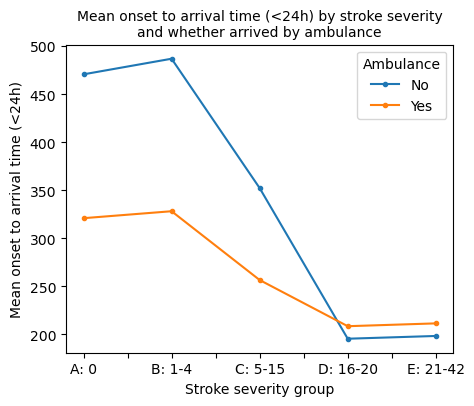

In [23]:
plot_by_severity('onset_to_arrival_time', 'onset to arrival time (<24h)',
                 dataset=onset_data)

### Arrival to scan time

Observations:
* In patients with short arrival to scan times, a very high proportion arrived by ambulance. The proportion is much lower for times apx. 2 hours to 7 hours, but then for the longer times, a higher proportion arrived by ambulance. It should be noted that, overall, a very small proportion of patients actually arrived at those later times.
* Relatedly, a greater proportion of patients who arrived by ambulance have shorter arrival to scan times.
* Over the years, the mean arrival to scan time follows a similar trend for ambulance arrivals versus not - decreasing, with a dip in 2020, and then increasing into 2021.

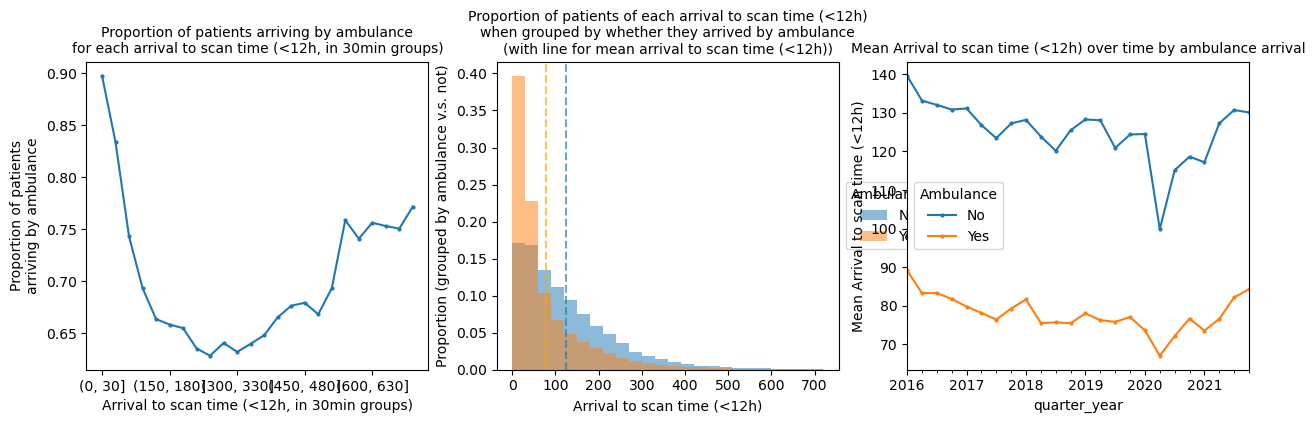

In [24]:
max = 12*60

# Convert continuous times into categories (every 30 minutes)
bins = np.arange(0, max+30, 30)
data_full['arrival_scan_cat'] = pd.cut(
    data_full['arrival_to_scan_time'], bins=bins)

# Drop times over 12 hours
onset_data = data_full[data_full['arrival_to_scan_time'] <= max]

# Set up figure
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

# Proportion arriving by ambulance in each time bucket
proportion_arrivals('arrival_scan_cat',
                    'Arrival to scan time (<12h, in 30min groups)',
                    ax=ax[0], type='line', dataset=onset_data)

# Distribution of onset to arrival time
proportions_by_arrival(
    'arrival_to_scan_time', 'Arrival to scan time (<12h)', ax=ax[1],
    type='hist', alt_bins='Yes', alt_bins_array=bins, dataset=onset_data)

# Mean time, over the years
mean_over_time('arrival_to_scan_time', 'Arrival to scan time (<12h)',
               ax=ax[2], dataset=onset_data)

The discrepancy in arrival to scan times is slightly less so for the lowest and highest stroke severities, although there remains a discrepancy for all severities.

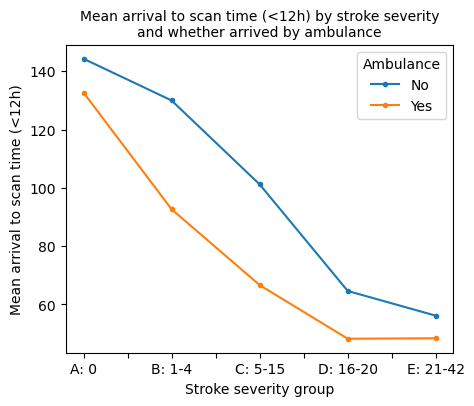

In [25]:
plot_by_severity('arrival_to_scan_time', 'arrival to scan time (<12h)',
                 dataset=onset_data)